# Logits Visualisierung - Sprachmodell

Dieses Notebook zeigt die Logits und Wahrscheinlichkeiten des trainierten Sprachmodells als Heatmaps und Diagramme.

In [322]:
import sys
from pathlib import Path

# src-Verzeichnis zum Python-Path hinzufügen
src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importiere Modell-Klassen
from training.training_lstm import load_model, Tokenizer, SimpleLanguageModel

# Stil setzen
plt.style.use('dark_background')
sns.set_theme(style='darkgrid')

print(f"Python-Path: {src_path}")
print("Bibliotheken geladen!")

Python-Path: C:\SDK\lm-stack\languageModel\src
Bibliotheken geladen!


## 1. Modell laden

In [323]:
# Modell laden - Pfad relativ zur Notebook-Position
model_dir = Path("../dist/lstm_model")

if not model_dir.exists():
    print("Modell nicht gefunden! Bitte zuerst trainieren:")
    print("  python src/main.py  (Option 1)")
else:
    model, tokenizer = load_model(str(model_dir))
    print(f"\nVokabular: {tokenizer.vocab_size} Wörter")

📂 Config geladen: ..\dist\lstm_model\config.json
🧠 Modell erstellt:
   - Embedding: 69 Wörter -> 32D Vektoren
   - LSTM: 32D -> 64D hidden
   - Output: 64D -> 69 Logits
📂 Modell geladen: ..\dist\lstm_model\model.pt
📂 Tokenizer geladen: ..\dist\lstm_model\tokenizer.json (69 Wörter)

✅ Modell bereit für Inferenz!

Vokabular: 69 Wörter


## 2. Logits für einen Text berechnen

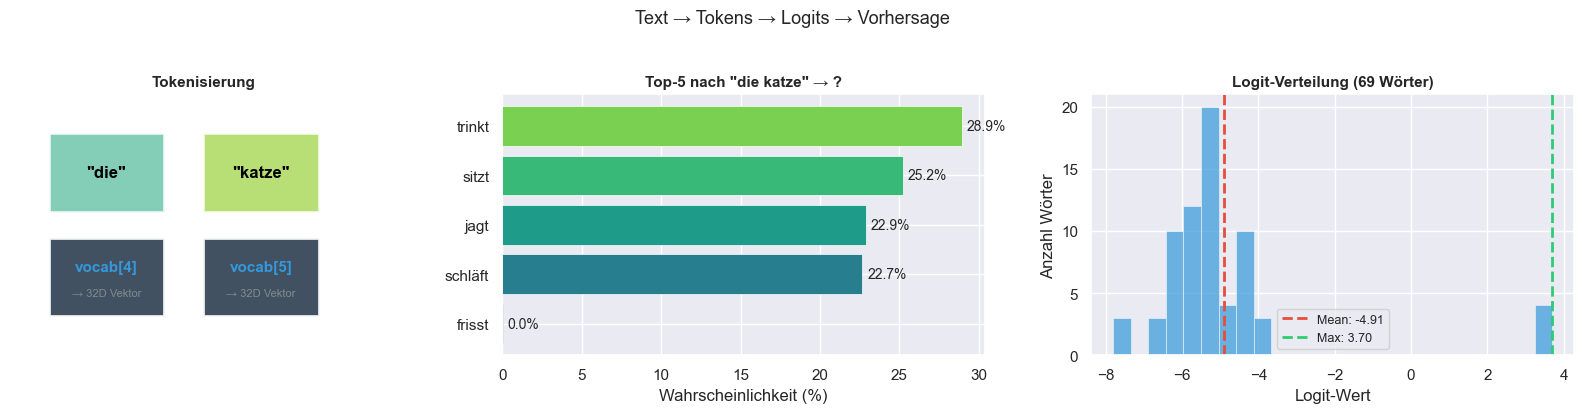

In [324]:
def get_logits_and_probs(model, tokenizer, text):
    """Berechnet Logits und Wahrscheinlichkeiten für den nächsten Token."""
    model.eval()
    tokens = tokenizer.encode(text)
    
    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)
        logits = model(input_tensor)
        last_logits = logits[0, -1, :]  # Nur letzter Token
        probs = F.softmax(last_logits, dim=-1)
    
    return last_logits.numpy(), probs.numpy(), tokens

# Test
test_text = "die katze"
logits, probs, tokens = get_logits_and_probs(model, tokenizer, test_text)
embed_dim = model.embedding.weight.shape[1]

# --- Visualisierung statt nur print ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4),
                         gridspec_kw={'width_ratios': [1.2, 1.5, 1.5]})

# 1. Tokenisierung als farbige Boxen
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 4)
ax1.set_title('Tokenisierung', fontsize=11, fontweight='bold')
words = test_text.split()
box_colors = plt.cm.Set2(np.linspace(0, 0.5, len(words)))
for i, (word, tok_id) in enumerate(zip(words, tokens)):
    x = 1 + i * 4
    # Wort-Box
    rect = plt.Rectangle((x, 2.2), 3, 1.2, linewidth=2,
                          edgecolor='white', facecolor=box_colors[i], alpha=0.8)
    ax1.add_patch(rect)
    ax1.text(x + 1.5, 2.8, f'"{word}"', ha='center', va='center',
             fontsize=12, fontweight='bold', color='black')
    # Pfeil
    ax1.annotate('', xy=(x + 1.5, 1.8), xytext=(x + 1.5, 2.2),
                 arrowprops=dict(arrowstyle='->', color='white', lw=1.5))
    # Token-ID Box mit Vocab-Info
    rect2 = plt.Rectangle((x, 0.6), 3, 1.2, linewidth=2,
                           edgecolor='white', facecolor='#2c3e50', alpha=0.9)
    ax1.add_patch(rect2)
    ax1.text(x + 1.5, 1.35, f'vocab[{tok_id}]', ha='center', va='center',
             fontsize=11, color='#3498db', fontweight='bold')
    ax1.text(x + 1.5, 0.95, f'→ {embed_dim}D Vektor', ha='center', va='center',
             fontsize=8, color='#7f8c8d')
ax1.axis('off')

# 2. Top-5 Vorhersagen (Mini-Balkendiagramm)
ax2 = axes[1]
top_k = 5
top_idx = np.argsort(probs)[-top_k:][::-1]
top_p = probs[top_idx]
top_w = [tokenizer.idx_to_word.get(i, "?") for i in top_idx]
colors = plt.cm.viridis(np.linspace(0.8, 0.3, top_k))
bars = ax2.barh(range(top_k), top_p * 100, color=colors, edgecolor='white', linewidth=0.5)
ax2.set_yticks(range(top_k))
ax2.set_yticklabels(top_w, fontsize=11)
ax2.set_xlabel('Wahrscheinlichkeit (%)')
ax2.set_title(f'Top-5 nach "{test_text}" → ?', fontsize=11, fontweight='bold')
ax2.invert_yaxis()
for bar, p in zip(bars, top_p):
    ax2.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
             f'{p*100:.1f}%', va='center', fontsize=10)

# 3. Logit-Verteilung (Histogramm)
ax3 = axes[2]
ax3.hist(logits, bins=25, color='#3498db', alpha=0.7, edgecolor='white', linewidth=0.5)
ax3.axvline(x=logits.mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {logits.mean():.2f}')
ax3.axvline(x=logits.max(), color='#2ecc71', linestyle='--', linewidth=2, label=f'Max: {logits.max():.2f}')
ax3.set_xlabel('Logit-Wert')
ax3.set_ylabel('Anzahl Wörter')
ax3.set_title(f'Logit-Verteilung ({len(logits)} Wörter)', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)

plt.suptitle(f'Text → Tokens → Logits → Vorhersage', fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

## 3. Top-K Balkendiagramm

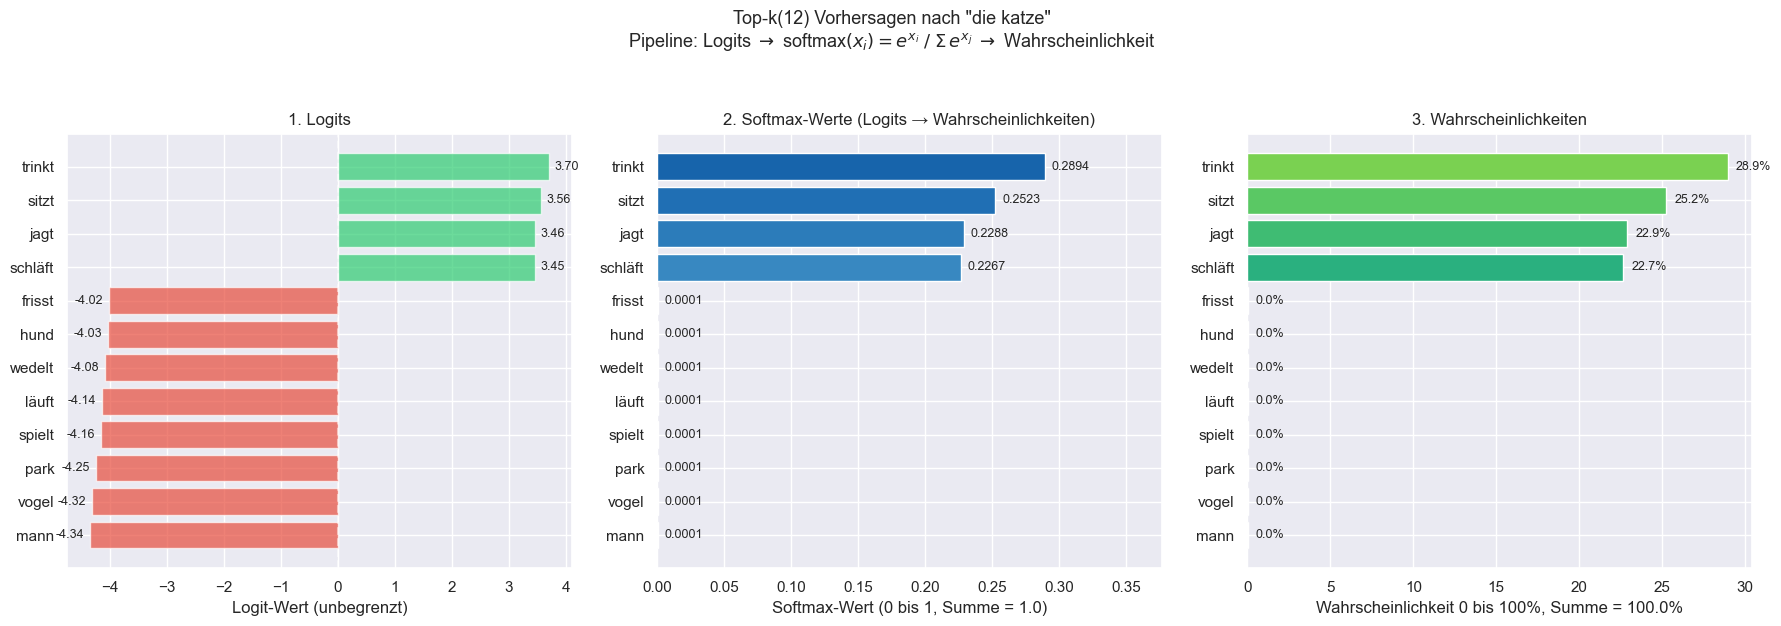

In [325]:
def plot_top_k_bar(model, tokenizer, text, top_k=15):
    """Zeigt die Top-K wahrscheinlichsten Wörter als Balkendiagramm.
    
    Visualisiert die komplette Pipeline:
    Logits (roh) → Softmax → Wahrscheinlichkeiten (%)
    """
    logits, probs, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Top-K finden
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_logits = logits[top_indices]
    top_words = [tokenizer.idx_to_word.get(i, "<UNK>") for i in top_indices]
    
    # 3 Subplots: Logits → Softmax → Wahrscheinlichkeiten
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- 1. Logits (vor Softmax) ---
    colors_logits = ['#2ecc71' if l > 0 else '#e74c3c' for l in top_logits]
    bars1 = ax1.barh(range(top_k), top_logits, color=colors_logits, alpha=0.7)
    ax1.set_yticks(range(top_k))
    ax1.set_yticklabels(top_words)
    ax1.set_xlabel('Logit-Wert (unbegrenzt)')
    ax1.set_title('1. Logits')
    ax1.axvline(x=0, color='white', linestyle='--', alpha=0.5)
    ax1.invert_yaxis()
    
    for bar, val in zip(bars1, top_logits):
        x_pos = bar.get_width() + 0.1 if val >= 0 else bar.get_width() - 0.1
        ha = 'left' if val >= 0 else 'right'
        ax1.text(x_pos, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center', ha=ha, fontsize=9)
    
    # --- 2. Softmax-Werte (nach Softmax) ---
    colors_softmax = plt.cm.Blues(np.linspace(0.8, 0.3, top_k))
    bars2 = ax2.barh(range(top_k), top_probs, color=colors_softmax)
    ax2.set_yticks(range(top_k))
    ax2.set_yticklabels(top_words)
    ax2.set_xlabel('Softmax-Wert (0 bis 1, Summe = 1.0)')
    ax2.set_title('2. Softmax-Werte (Logits \u2192 Wahrscheinlichkeiten)')
    ax2.set_xlim(0, min(1.0, top_probs[0] * 1.3))
    ax2.invert_yaxis()
    
    for bar, val in zip(bars2, top_probs):
        ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9)
    
    # --- 3. Wahrscheinlichkeiten (%) ---
    colors_prob = plt.cm.viridis(np.linspace(0.8, 0.2, top_k))
    bars3 = ax3.barh(range(top_k), top_probs * 100, color=colors_prob)
    ax3.set_yticks(range(top_k))
    ax3.set_yticklabels(top_words)
    ax3.set_xlabel('Wahrscheinlichkeit 0 bis 100%, Summe = 100.0%')
    ax3.set_title('3. Wahrscheinlichkeiten')
    ax3.invert_yaxis()
    
    for bar, prob in zip(bars3, top_probs):
        ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{prob*100:.1f}%', va='center', fontsize=9)
    
    fig.suptitle(f'Top-k({top_k}) Vorhersagen nach "{text}"\n'
                 r'Pipeline: Logits $\rightarrow$ softmax$(x_i) = e^{x_i} \;/\; \Sigma \, e^{x_j}$ $\rightarrow$ Wahrscheinlichkeit',
                 fontsize=13, y=1.04)
    plt.tight_layout()
    plt.show()
    
    return top_words, top_probs, top_logits

# Visualisieren
plot_top_k_bar(model, tokenizer, "die katze", top_k=12);

## 4. Vollständige Logits-Heatmap (alle Wörter)

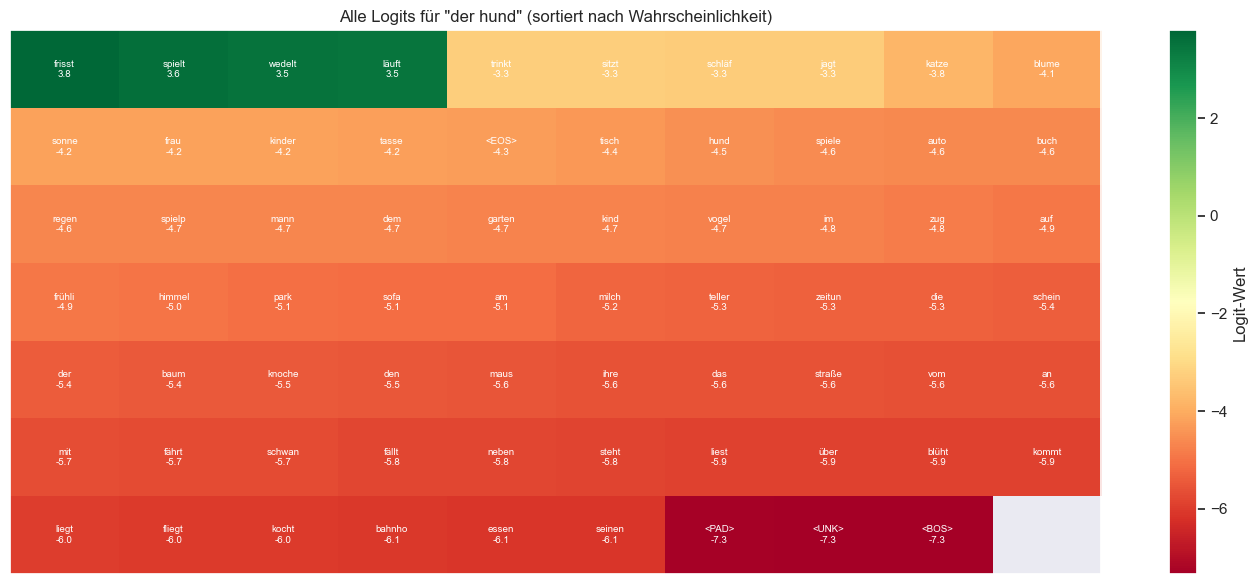

In [326]:
def plot_full_logits_heatmap(model, tokenizer, text):
    """Zeigt alle Logits als Heatmap - ein Wert pro Wort im Vokabular."""
    logits, probs, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Sortiere nach Wahrscheinlichkeit
    sorted_indices = np.argsort(probs)[::-1]
    sorted_logits = logits[sorted_indices]
    sorted_words = [tokenizer.idx_to_word.get(i, "?")[:10] for i in sorted_indices]
    
    # Heatmap (als 2D-Matrix reshaped)
    n_words = len(sorted_logits)
    cols = 10
    rows = (n_words + cols - 1) // cols
    
    # Padding falls nötig
    padded_logits = np.pad(sorted_logits, (0, rows * cols - n_words), constant_values=np.nan)
    matrix = padded_logits.reshape(rows, cols)
    
    fig, ax = plt.subplots(figsize=(14, max(6, rows * 0.5)))
    
    im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto')
    plt.colorbar(im, ax=ax, label='Logit-Wert')
    
    # Labels
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < n_words:
                word = sorted_words[idx][:6]
                val = sorted_logits[idx]
                color = 'white' if abs(val) > 1 else 'black'
                ax.text(j, i, f"{word}\n{val:.1f}", ha='center', va='center', 
                       fontsize=7, color=color)
    
    ax.set_title(f'Alle Logits für "{text}" (sortiert nach Wahrscheinlichkeit)')
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

plot_full_logits_heatmap(model, tokenizer, "der hund")

## 5. Generierungsprozess Schritt für Schritt

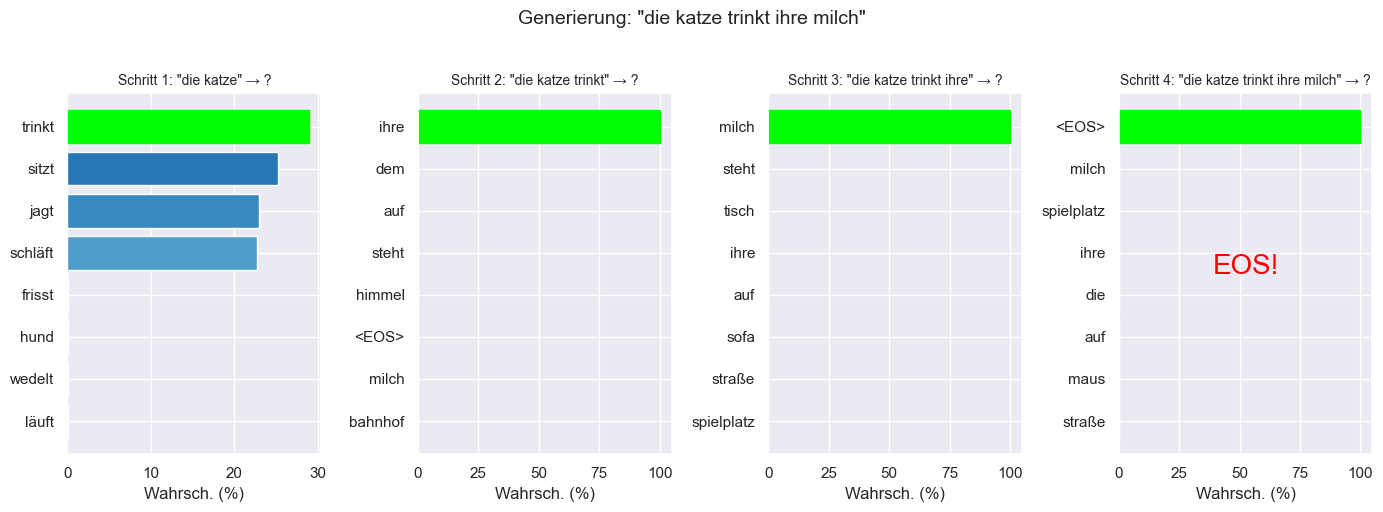

In [327]:
def visualize_generation_steps(model, tokenizer, start_text, max_steps=6, top_k=8):
    """Visualisiert jeden Schritt der Text-Generierung."""
    model.eval()
    
    tokens = tokenizer.encode(start_text)
    generated_words = start_text.split()
    
    # Erst alle Schritte berechnen, dann plotten
    steps_data = []
    
    for step in range(max_steps):
        context = tokens[-5:] if len(tokens) > 5 else tokens
        
        with torch.no_grad():
            input_tensor = torch.tensor(context).unsqueeze(0)
            logits = model(input_tensor)
            last_logits = logits[0, -1, :]
            probs = F.softmax(last_logits, dim=-1).numpy()
        
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_probs = probs[top_indices]
        top_words = [tokenizer.idx_to_word.get(i, "?") for i in top_indices]
        
        next_token = top_indices[0]
        next_word = top_words[0]
        context_text = tokenizer.decode(context)
        
        steps_data.append({
            'top_probs': top_probs,
            'top_words': top_words,
            'context_text': context_text,
            'next_token': next_token,
        })
        
        # EOS Check
        if next_token == tokenizer.word_to_idx.get(tokenizer.eos_token):
            break
        
        tokens.append(next_token)
        generated_words.append(next_word)
    
    # Alle Schritte nebeneinander – Breite passt sich exakt an Anzahl an
    n_steps = len(steps_data)
    fig, axes = plt.subplots(1, n_steps, figsize=(3.5 * n_steps, 5),
                             squeeze=False)
    axes = axes[0]  # squeeze=False gibt 2D-Array, erste Zeile nehmen
    
    for step, (ax, data) in enumerate(zip(axes, steps_data)):
        colors = plt.cm.Blues(np.linspace(0.8, 0.3, top_k))
        bars = ax.barh(range(top_k), data['top_probs'] * 100, color=colors)
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(data['top_words'])
        ax.set_xlabel('Wahrsch. (%)')
        ax.set_title(f'Schritt {step+1}: "{data["context_text"]}" → ?', fontsize=10)
        ax.invert_yaxis()
        
        # Markiere gewähltes Wort
        bars[0].set_color('lime')
        
        if data['next_token'] == tokenizer.word_to_idx.get(tokenizer.eos_token):
            ax.annotate('EOS!', xy=(0.5, 0.5), xycoords='axes fraction',
                       fontsize=20, color='red', ha='center')
    
    plt.suptitle(f'Generierung: "{" ".join(generated_words)}"', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return " ".join(generated_words)

# Visualisieren
result = visualize_generation_steps(model, tokenizer, "die katze", max_steps=6)

## 6. Vergleich mehrerer Eingaben

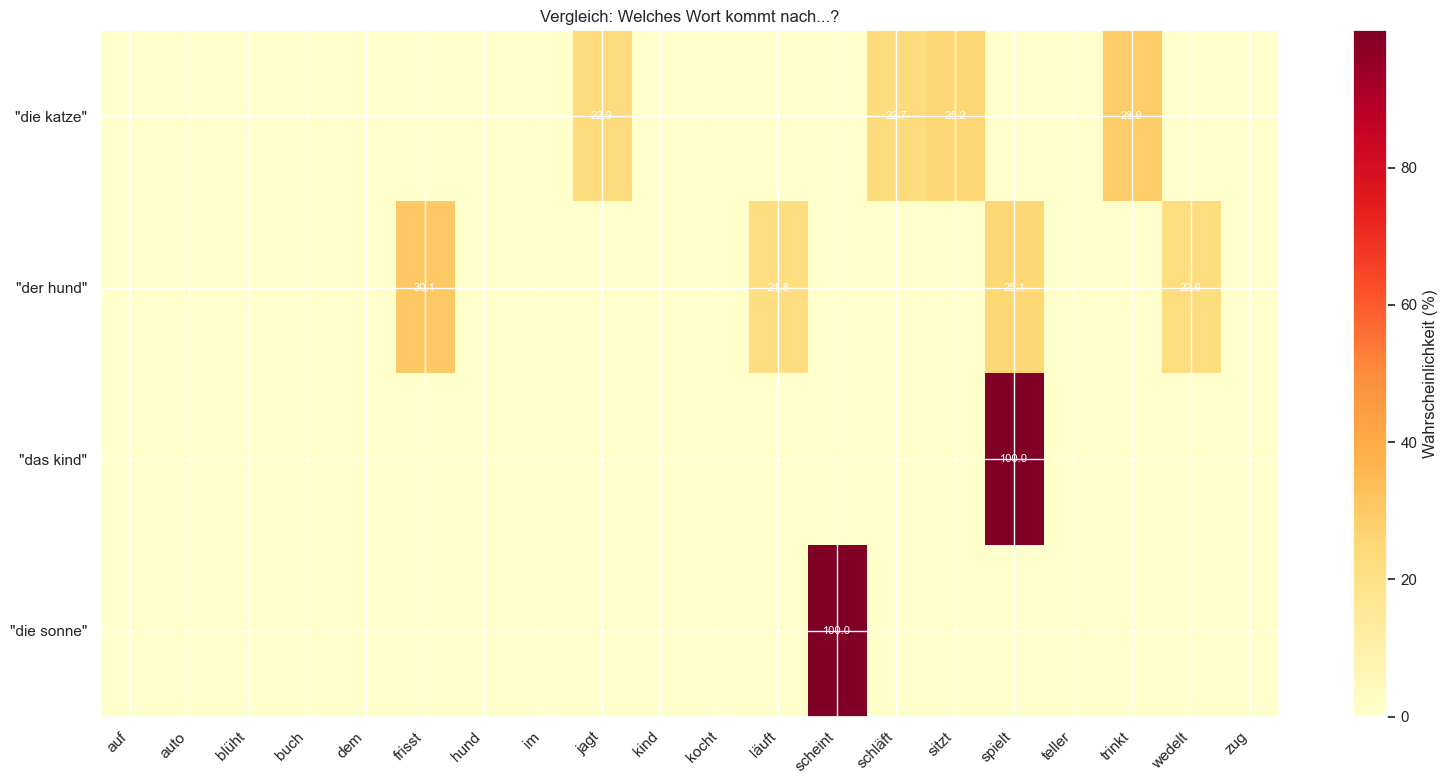

In [328]:
def compare_inputs_heatmap(model, tokenizer, texts, top_k=10):
    """Vergleicht die Top-K Vorhersagen für mehrere Eingaben als Heatmap."""
    
    # Sammle alle Top-Wörter
    all_top_words = set()
    text_probs = {}
    
    for text in texts:
        _, probs, _ = get_logits_and_probs(model, tokenizer, text)
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_words = [tokenizer.idx_to_word.get(i, "?") for i in top_indices]
        all_top_words.update(top_words)
        text_probs[text] = {tokenizer.idx_to_word.get(i, "?"): probs[i] for i in top_indices}
    
    # Sortiere Wörter
    all_top_words = sorted(all_top_words)
    
    # Erstelle Matrix
    matrix = np.zeros((len(texts), len(all_top_words)))
    for i, text in enumerate(texts):
        for j, word in enumerate(all_top_words):
            matrix[i, j] = text_probs[text].get(word, 0) * 100
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(12, len(all_top_words) * 0.8), len(texts) * 1.5 + 2))
    
    im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto')
    plt.colorbar(im, ax=ax, label='Wahrscheinlichkeit (%)')
    
    ax.set_xticks(range(len(all_top_words)))
    ax.set_xticklabels(all_top_words, rotation=45, ha='right')
    ax.set_yticks(range(len(texts)))
    ax.set_yticklabels([f'"{t}"' for t in texts])
    
    # Werte in Zellen
    for i in range(len(texts)):
        for j in range(len(all_top_words)):
            val = matrix[i, j]
            if val > 0.5:
                color = 'white' if val > 5 else 'black'
                ax.text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=8, color=color)
    
    ax.set_title('Vergleich: Welches Wort kommt nach...?')
    plt.tight_layout()
    plt.show()

# Vergleiche
compare_inputs_heatmap(model, tokenizer, [
    "die katze",
    "der hund",
    "das kind",
    "die sonne"
], top_k=8)

## 7. Wahrscheinlichkeitsverteilung (Pie Chart)

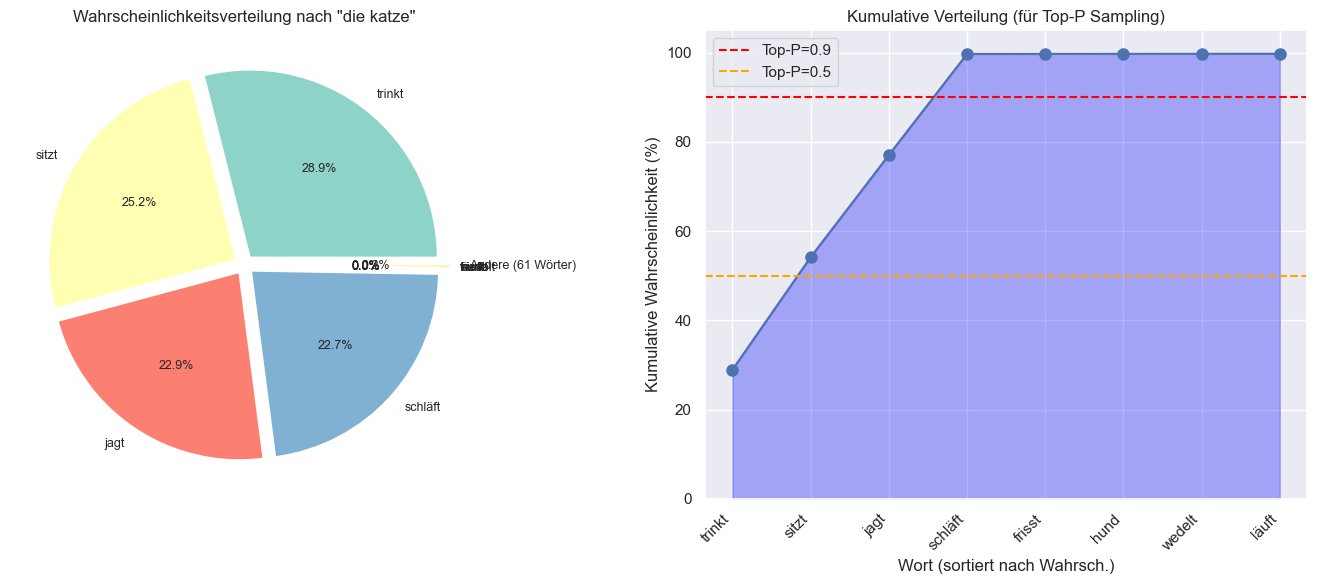

In [329]:
def plot_probability_pie(model, tokenizer, text, top_k=8):
    """Zeigt die Wahrscheinlichkeitsverteilung als Kreisdiagramm."""
    _, probs, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Top-K + Rest
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_words = [tokenizer.idx_to_word.get(i, "?") for i in top_indices]
    
    rest_prob = 1.0 - sum(top_probs)
    
    labels = top_words + [f'Andere ({tokenizer.vocab_size - top_k} Wörter)']
    sizes = list(top_probs) + [rest_prob]
    
    # Farben
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie Chart
    explode = [0.05] * top_k + [0.1]
    wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                                        explode=explode, colors=colors, 
                                        textprops={'fontsize': 9})
    ax1.set_title(f'Wahrscheinlichkeitsverteilung nach "{text}"')
    
    # Kumulative Verteilung
    cumsum = np.cumsum(top_probs)
    ax2.fill_between(range(top_k), cumsum * 100, alpha=0.3, color='blue')
    ax2.plot(range(top_k), cumsum * 100, 'bo-', markersize=8)
    ax2.set_xticks(range(top_k))
    ax2.set_xticklabels(top_words, rotation=45, ha='right')
    ax2.set_ylabel('Kumulative Wahrscheinlichkeit (%)')
    ax2.set_xlabel('Wort (sortiert nach Wahrsch.)')
    ax2.set_title('Kumulative Verteilung (für Top-P Sampling)')
    ax2.axhline(y=90, color='red', linestyle='--', label='Top-P=0.9')
    ax2.axhline(y=50, color='orange', linestyle='--', label='Top-P=0.5')
    ax2.legend()
    ax2.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()

plot_probability_pie(model, tokenizer, "die katze", top_k=8)

## 8. Interaktive Eingabe

Analyse für: 'die katze'



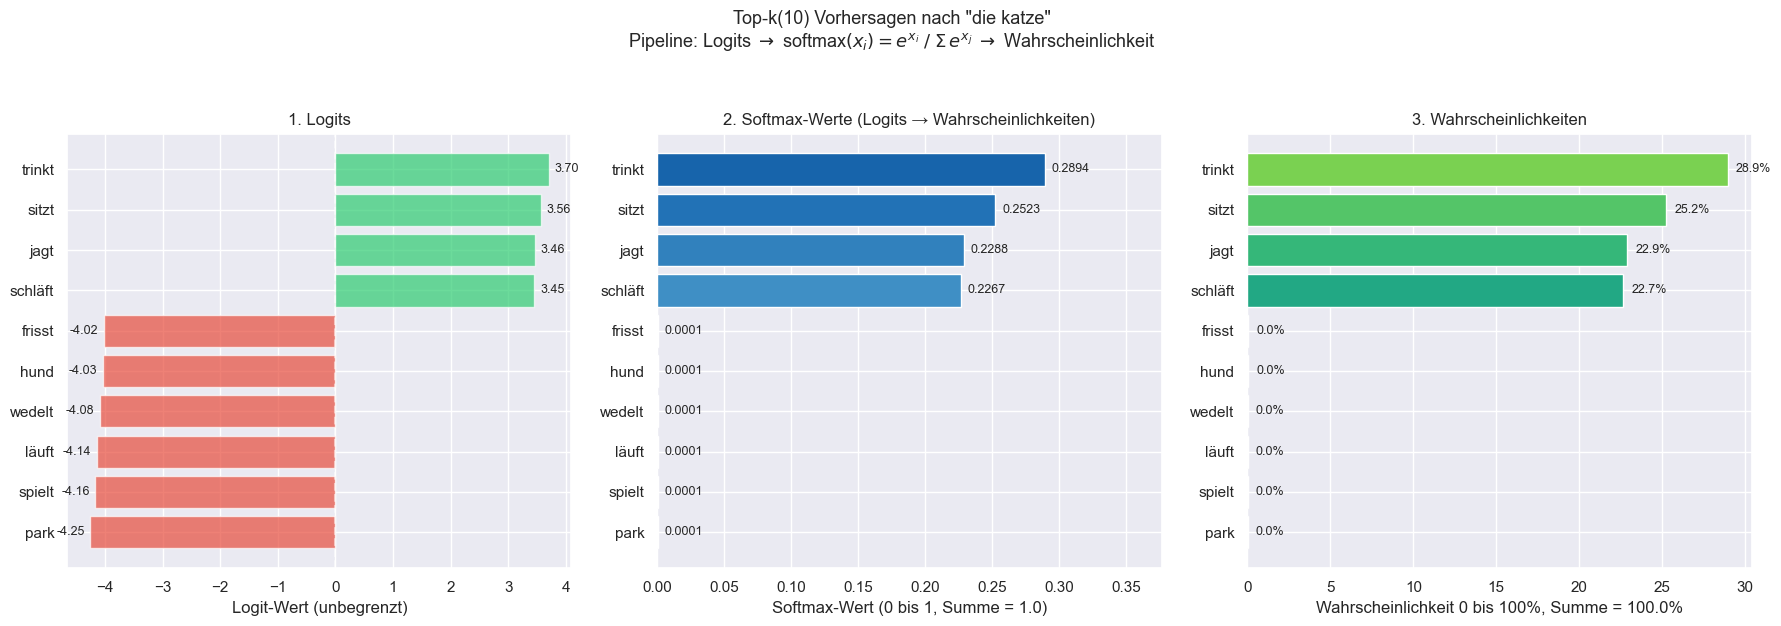

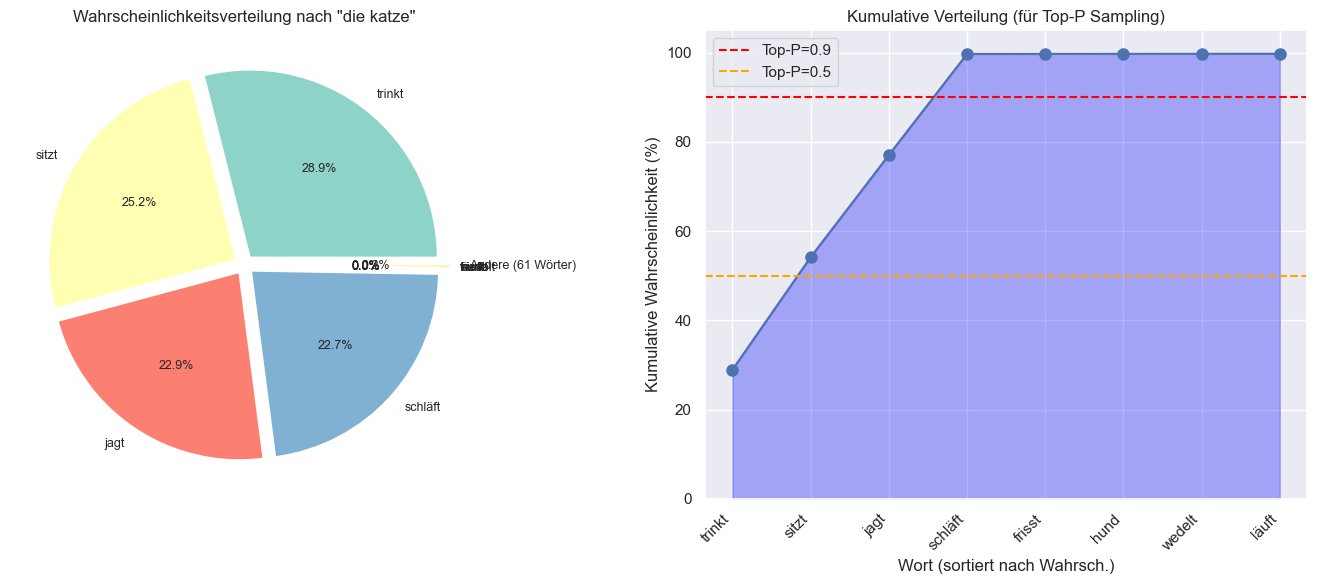

In [330]:
# Eigenen Text eingeben und analysieren
eingabe = "die katze"  # <-- Hier eigenen Text eingeben!

print(f"Analyse für: '{eingabe}'\n")
print("=" * 50)

# Alle Visualisierungen
plot_top_k_bar(model, tokenizer, eingabe, top_k=10)
plot_probability_pie(model, tokenizer, eingabe, top_k=8)

## 9. Temperatur-Vergleich

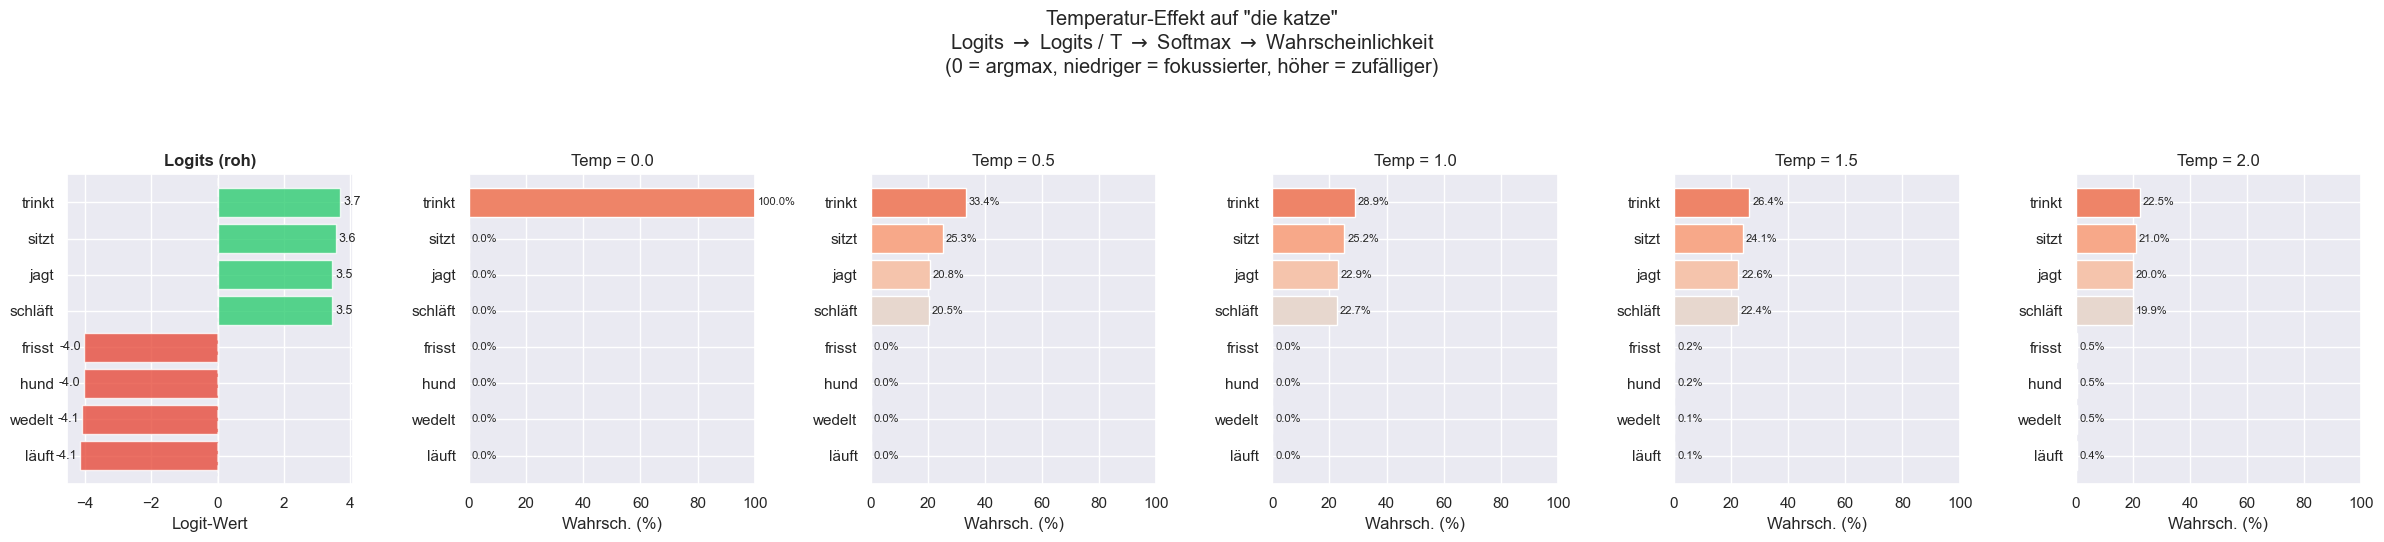

In [331]:
def compare_temperatures(model, tokenizer, text, temperatures=[0.0, 0.5, 1.0, 1.5, 2.0], top_k=8):
    """Zeigt wie Temperature die Wahrscheinlichkeitsverteilung beeinflusst.
    
    Temperature = 0: Argmax (deterministisch, Top-Wort bekommt 100%)
    Temperature = 1: Standard Softmax
    Temperature > 1: Flachere Verteilung (mehr Zufall)
    Temperature < 1: Schärfere Verteilung (weniger Zufall)
    """
    logits, _, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Top-K basierend auf originalen Logits (gleich für alle Temperaturen!)
    top_indices = np.argsort(logits)[-top_k:][::-1]
    top_words = [tokenizer.idx_to_word.get(i, "?")[:8] for i in top_indices]
    top_logits = logits[top_indices]
    
    # 1 Logit-Panel + N Temperatur-Panels
    n_panels = 1 + len(temperatures)
    fig, axes = plt.subplots(1, n_panels, figsize=(4 * n_panels, 5))
    
    # --- 1. Rohe Logits (vor Softmax) ---
    ax0 = axes[0]
    colors_logits = ['#2ecc71' if l > 0 else '#e74c3c' for l in top_logits]
    bars0 = ax0.barh(range(top_k), top_logits, color=colors_logits, alpha=0.8)
    ax0.set_yticks(range(top_k))
    ax0.set_yticklabels(top_words)
    ax0.set_xlabel('Logit-Wert')
    ax0.set_title('Logits (roh)', fontweight='bold')
    ax0.axvline(x=0, color='white', linestyle='--', alpha=0.5)
    ax0.invert_yaxis()
    for bar, val in zip(bars0, top_logits):
        x_pos = bar.get_width() + 0.1 if val >= 0 else bar.get_width() - 0.1
        ha = 'left' if val >= 0 else 'right'
        ax0.text(x_pos, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}', va='center', ha=ha, fontsize=9)
    
    # --- 2-N. Temperatur-Panels ---
    for ax, temp in zip(axes[1:], temperatures):
        if temp == 0:
            # Temperatur 0 = Argmax: Top-Wort bekommt 100%, Rest 0%
            probs = np.zeros_like(logits)
            probs[np.argmax(logits)] = 1.0
        else:
            # Logits mit Temperature skalieren
            scaled_logits = logits / temp
            probs = F.softmax(torch.tensor(scaled_logits), dim=-1).numpy()

        # Wahrscheinlichkeiten für die (gleichen) Top-K Wörter
        top_probs = probs[top_indices]
        
        # Plot
        colors = plt.cm.coolwarm(np.linspace(0.8, 0.2, top_k))
        bars = ax.barh(range(top_k), top_probs * 100, color=colors)
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(top_words)
        ax.set_xlabel('Wahrsch. (%)')
        ax.set_title(f'Temp = {temp}')
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
        
        # %-Werte neben den Balken
        for bar, p in zip(bars, top_probs):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{p*100:.1f}%', va='center', fontsize=8)
    
    plt.suptitle(f'Temperatur-Effekt auf "{text}"\n'
                 r'Logits $\rightarrow$ Logits / T $\rightarrow$ Softmax $\rightarrow$ Wahrscheinlichkeit'
                 '\n(0 = argmax, niedriger = fokussierter, höher = zufälliger)', y=1.08)
    plt.tight_layout()
    plt.show()

compare_temperatures(model, tokenizer, "die katze")

## 10. Embedding-Visualisierung

Embeddings sind hochdimensionale Vektoren (z.B. 32D), die jedes Wort im Vokabular repräsentieren.
Ähnliche Wörter sollten ähnliche Vektoren haben und im Embedding-Raum nahe beieinander liegen.

**Visualisierungsmethoden:**
- **PCA** (Principal Component Analysis): Schnell, linear, zeigt globale Struktur
- **t-SNE**: Langsamer, nicht-linear, zeigt Cluster besser

Das Modell lernt diese Vektoren während des Trainings!

In [332]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embeddings_pca(model, tokenizer, highlight_words=None, figsize=(12, 10)):
    """
    Visualisiert die Embedding-Vektoren mit PCA (2D Projektion).
    
    Args:
        model: Das trainierte Modell
        tokenizer: Der Tokenizer mit dem Vokabular
        highlight_words: Liste von Wörtern, die hervorgehoben werden sollen
        figsize: Größe der Figur
    """
    # Embedding-Gewichte extrahieren
    embeddings = model.embedding.weight.detach().numpy()
    vocab_size, embed_dim = embeddings.shape
    
    print(f"Embedding-Matrix: {vocab_size} Wörter × {embed_dim} Dimensionen")
    
    # PCA auf 2D reduzieren
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    print(f"Erklärte Varianz: {pca.explained_variance_ratio_.sum()*100:.1f}%")
    print(f"  - PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
    print(f"  - PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Alle Wörter als Punkte
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
               alpha=0.6, s=50, c='steelblue')
    
    # Wörter beschriften
    for i in range(vocab_size):
        word = tokenizer.idx_to_word.get(i, f"[{i}]")
        x, y = embeddings_2d[i]
        
        # Hervorheben falls in Liste
        if highlight_words and word in highlight_words:
            ax.scatter([x], [y], s=200, c='red', marker='*', zorder=5)
            ax.annotate(word, (x, y), fontsize=12, fontweight='bold',
                       color='red', ha='center', va='bottom',
                       xytext=(0, 8), textcoords='offset points')
        else:
            ax.annotate(word, (x, y), fontsize=8, alpha=0.7,
                       ha='center', va='bottom')
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title('Embedding-Visualisierung (PCA)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, pca


def plot_embeddings_tsne(model, tokenizer, perplexity=5, figsize=(12, 10)):
    """
    Visualisiert die Embedding-Vektoren mit t-SNE (2D Projektion).
    t-SNE ist besser für Cluster, aber langsamer und nicht deterministisch.
    
    Args:
        model: Das trainierte Modell
        tokenizer: Der Tokenizer mit dem Vokabular
        perplexity: t-SNE Parameter (5-50, kleiner = lokaler Fokus)
        figsize: Größe der Figur
    """
    # Embedding-Gewichte extrahieren
    embeddings = model.embedding.weight.detach().numpy()
    vocab_size, embed_dim = embeddings.shape
    
    print(f"Embedding-Matrix: {vocab_size} Wörter × {embed_dim} Dimensionen")
    print(f"t-SNE mit perplexity={perplexity}...")
    
    # t-SNE auf 2D reduzieren
    tsne = TSNE(n_components=2, perplexity=min(perplexity, vocab_size-1), 
                random_state=42, n_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Farben nach Wortart (einfache Heuristik)
    colors = []
    for i in range(vocab_size):
        word = tokenizer.idx_to_word.get(i, "")
        if word.startswith("<"):  # Special tokens
            colors.append('gray')
        elif word in ['der', 'die', 'das', 'den', 'dem', 'ein', 'eine']:
            colors.append('green')  # Artikel
        elif word in ['auf', 'in', 'im', 'am', 'vom', 'mit', 'über', 'neben']:
            colors.append('orange')  # Präpositionen
        else:
            colors.append('steelblue')  # Rest
    
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
               alpha=0.7, s=80, c=colors)
    
    # Wörter beschriften
    for i in range(vocab_size):
        word = tokenizer.idx_to_word.get(i, f"[{i}]")
        x, y = embeddings_2d[i]
        ax.annotate(word, (x, y), fontsize=8, alpha=0.8,
                   ha='center', va='bottom')
    
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_title('Embedding-Visualisierung (t-SNE)')
    ax.grid(True, alpha=0.3)
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Artikel'),
        Patch(facecolor='orange', label='Präpositionen'),
        Patch(facecolor='steelblue', label='Andere'),
        Patch(facecolor='gray', label='Special Tokens')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d


def plot_embedding_similarity(model, tokenizer, words, figsize=(10, 8)):
    """
    Zeigt die Kosinus-Ähnlichkeit zwischen ausgewählten Wörtern als Heatmap.
    
    Args:
        model: Das trainierte Modell
        tokenizer: Der Tokenizer
        words: Liste von Wörtern zum Vergleichen
    """
    # Embedding-Vektoren für die Wörter holen
    embeddings = model.embedding.weight.detach().numpy()
    
    word_indices = []
    valid_words = []
    for word in words:
        idx = tokenizer.word_to_idx.get(word.lower())
        if idx is not None:
            word_indices.append(idx)
            valid_words.append(word)
        else:
            print(f"Warnung: '{word}' nicht im Vokabular")
    
    if len(valid_words) < 2:
        print("Mindestens 2 gültige Wörter benötigt!")
        return
    
    # Embedding-Vektoren extrahieren
    word_embeddings = embeddings[word_indices]
    
    # Kosinus-Ähnlichkeit berechnen
    # cos_sim(a, b) = (a · b) / (||a|| * ||b||)
    norms = np.linalg.norm(word_embeddings, axis=1, keepdims=True)
    normalized = word_embeddings / norms
    similarity_matrix = normalized @ normalized.T
    
    # Heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    im = ax.imshow(similarity_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax, label='Kosinus-Ähnlichkeit')
    
    ax.set_xticks(range(len(valid_words)))
    ax.set_yticks(range(len(valid_words)))
    ax.set_xticklabels(valid_words, rotation=45, ha='right')
    ax.set_yticklabels(valid_words)
    
    # Werte in Zellen
    for i in range(len(valid_words)):
        for j in range(len(valid_words)):
            val = similarity_matrix[i, j]
            color = 'white' if abs(val) > 0.5 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                   fontsize=10, color=color)
    
    ax.set_title('Embedding-Ähnlichkeit (Kosinus)')
    plt.tight_layout()
    plt.show()
    
    return similarity_matrix, valid_words


print("Embedding-Visualisierungsfunktionen geladen!")

Embedding-Visualisierungsfunktionen geladen!


Embedding-Matrix: 69 Wörter × 32 Dimensionen
Erklärte Varianz: 13.8%
  - PC1: 7.2%
  - PC2: 6.7%


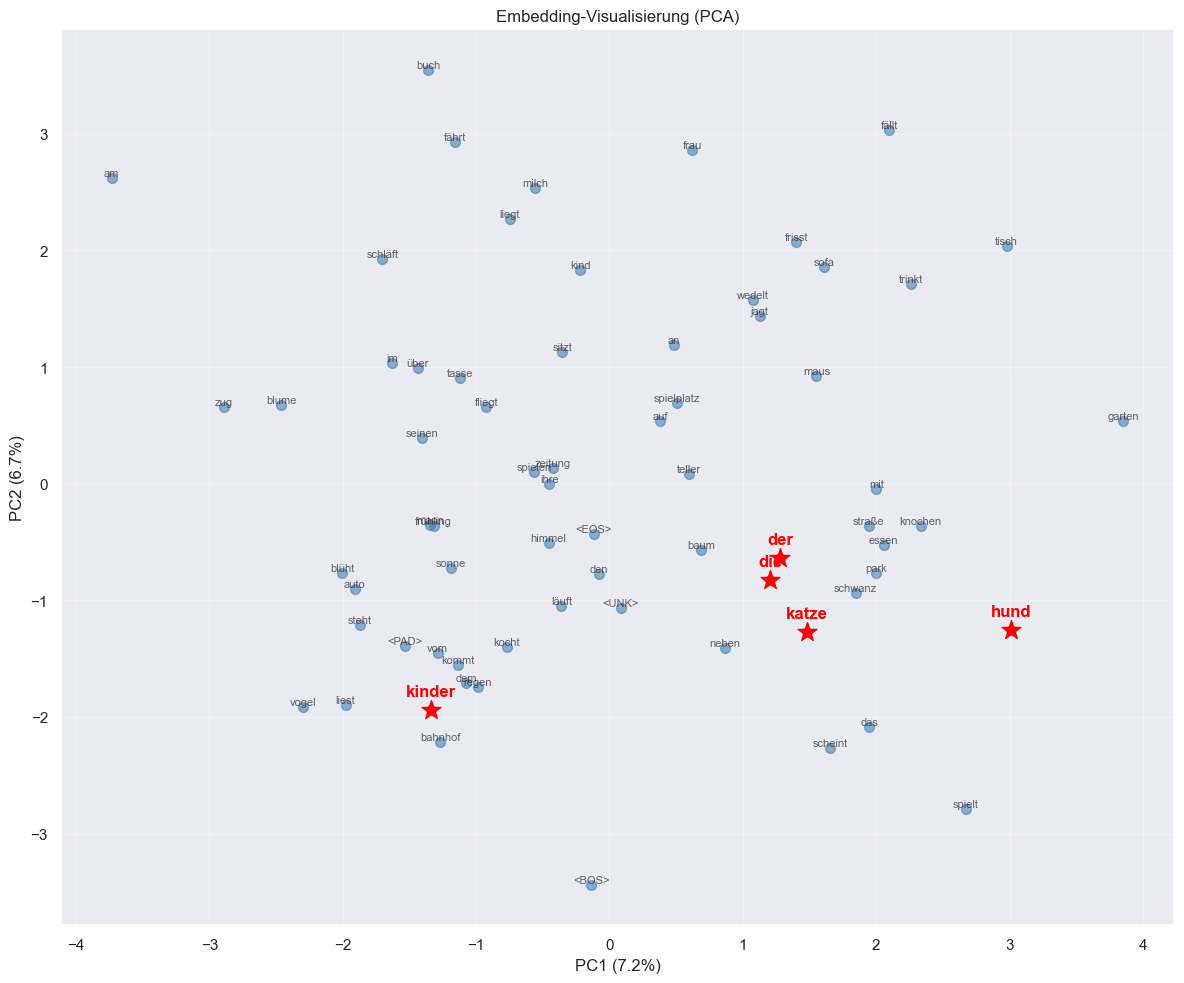

(array([[-1.5304691 , -1.3959515 ],
        [ 0.08455811, -1.0675147 ],
        [-0.13627872, -3.4370704 ],
        [-0.11590305, -0.42712253],
        [ 1.2031846 , -0.82695603],
        [ 1.4832015 , -1.2705818 ],
        [-0.3549138 ,  1.1321158 ],
        [ 0.38111347,  0.53635025],
        [-1.0735139 , -1.7128241 ],
        [ 2.9777627 ,  2.0390346 ],
        [ 1.2810693 , -0.6372855 ],
        [ 3.0124834 , -1.252567  ],
        [-0.36012533, -1.0480647 ],
        [-1.629864  ,  1.0314828 ],
        [ 3.8536098 ,  0.541738  ],
        [-1.7036692 ,  1.9230827 ],
        [ 1.6083689 ,  1.8599852 ],
        [ 2.670123  , -2.786241  ],
        [ 2.0007071 , -0.7633859 ],
        [-1.1863843 , -0.72205925],
        [ 1.6545868 , -2.2637415 ],
        [-3.7324228 ,  2.624733  ],
        [-0.45673168, -0.50984967],
        [-2.3004715 , -1.913994  ],
        [-0.9243284 ,  0.6581447 ],
        [-1.4389697 ,  0.9959574 ],
        [-0.07901016, -0.7733757 ],
        [ 0.68662006, -0.566

In [333]:
# PCA Visualisierung - alle Wörter im 2D-Raum
# Ähnliche Wörter sollten nahe beieinander liegen
plot_embeddings_pca(model, tokenizer, highlight_words=['katze', 'hund', 'die', 'der', 'kinder'])

Embedding-Matrix: 69 Wörter × 32 Dimensionen
t-SNE mit perplexity=8...


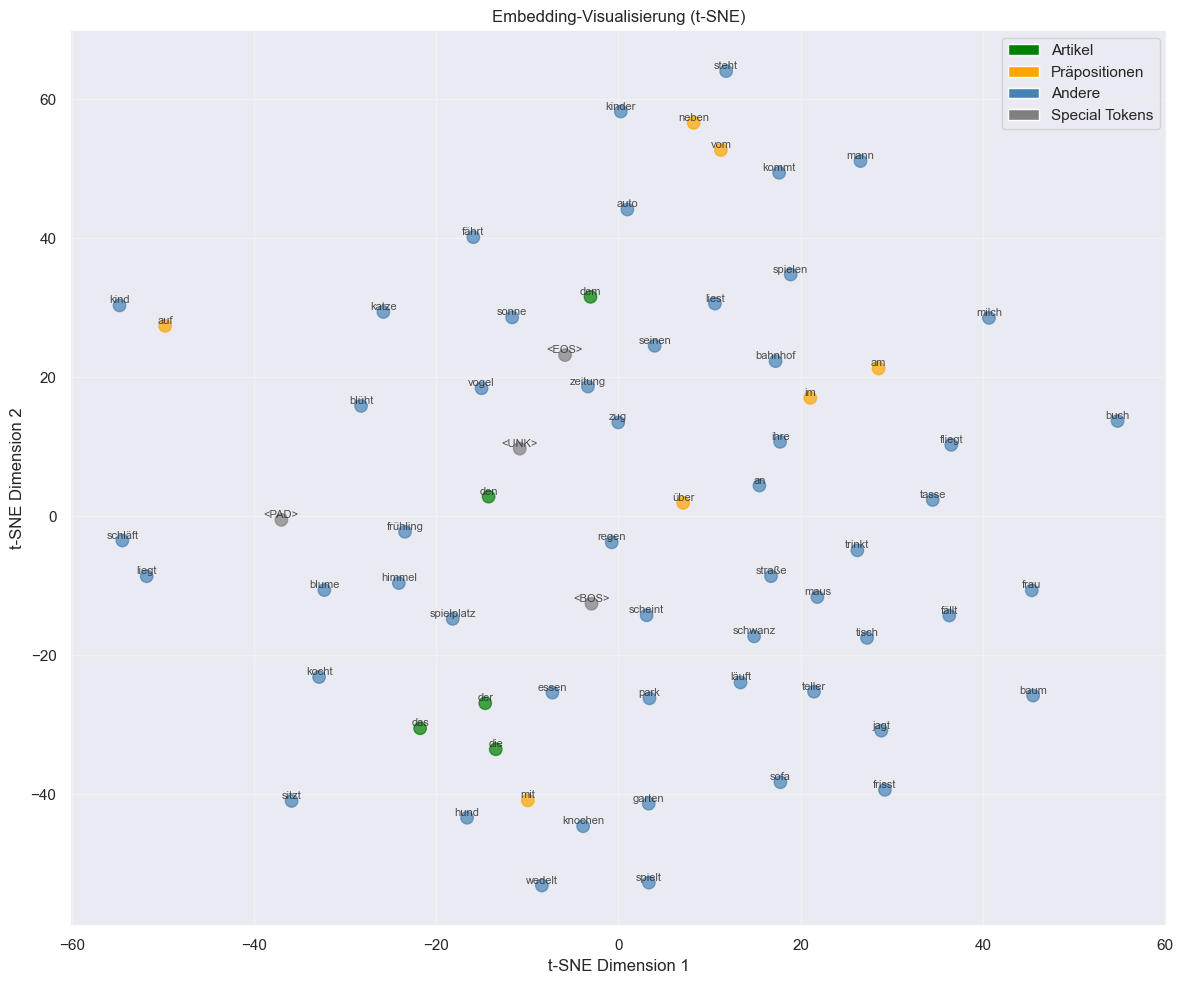

array([[-3.69993439e+01, -5.00359654e-01],
       [-1.08330345e+01,  9.74487209e+00],
       [-2.95457458e+00, -1.25726519e+01],
       [-5.86273718e+00,  2.32020969e+01],
       [-1.34680481e+01, -3.35007896e+01],
       [-2.58027954e+01,  2.94074745e+01],
       [-3.58761215e+01, -4.09373932e+01],
       [-4.97529984e+01,  2.74026928e+01],
       [-3.06562829e+00,  3.15772324e+01],
       [ 2.72895794e+01, -1.74850082e+01],
       [-1.46234102e+01, -2.68802795e+01],
       [-1.66158447e+01, -4.33522949e+01],
       [ 1.34019585e+01, -2.38940163e+01],
       [ 2.10608120e+01,  1.70369282e+01],
       [ 3.32362700e+00, -4.13326263e+01],
       [-5.44517670e+01, -3.47265148e+00],
       [ 1.77759418e+01, -3.82471581e+01],
       [ 3.34151697e+00, -5.26829185e+01],
       [ 3.40158343e+00, -2.61733551e+01],
       [-1.16692972e+01,  2.86177197e+01],
       [ 3.09361100e+00, -1.42304144e+01],
       [ 2.85549774e+01,  2.12743492e+01],
       [-2.41069927e+01, -9.59484768e+00],
       [-1.

In [334]:
# t-SNE Visualisierung - zeigt Cluster besser
# Farben: Grün=Artikel, Orange=Präpositionen, Blau=Rest
plot_embeddings_tsne(model, tokenizer, perplexity=8)

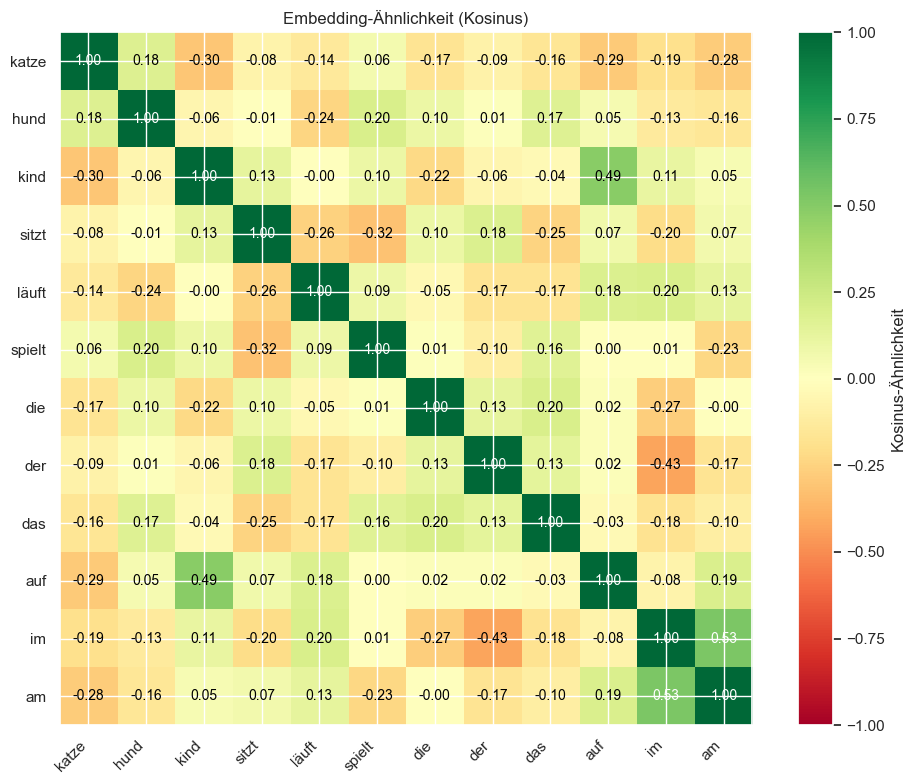

(array([[ 1.00000012e+00,  1.76513121e-01, -3.01174372e-01,
         -7.54796490e-02, -1.36349827e-01,  5.71948998e-02,
         -1.68851465e-01, -8.59187171e-02, -1.58525646e-01,
         -2.86300212e-01, -1.93150595e-01, -2.75119156e-01],
        [ 1.76513121e-01,  1.00000000e+00, -5.61962835e-02,
         -5.33631304e-03, -2.35720381e-01,  1.97180763e-01,
          9.53129828e-02,  1.38785681e-02,  1.71292409e-01,
          4.83003296e-02, -1.30427584e-01, -1.55035138e-01],
        [-3.01174372e-01, -5.61962835e-02,  1.00000012e+00,
          1.27925992e-01, -2.10930803e-03,  9.52404439e-02,
         -2.20299006e-01, -5.87691553e-02, -3.52614224e-02,
          4.90978003e-01,  1.10588841e-01,  4.50157523e-02],
        [-7.54796490e-02, -5.33631304e-03,  1.27925992e-01,
          1.00000000e+00, -2.57795155e-01, -3.15542787e-01,
          9.72709432e-02,  1.82099223e-01, -2.49011874e-01,
          7.43640810e-02, -2.04725429e-01,  6.68073222e-02],
        [-1.36349827e-01, -2.3572038

In [335]:
# Ähnlichkeits-Heatmap für ausgewählte Wörter
# Wert 1.0 = identisch, 0 = unkorreliert, -1 = entgegengesetzt
plot_embedding_similarity(model, tokenizer, [
    'katze', 'hund', 'kind',      # Subjekte
    'sitzt', 'läuft', 'spielt',   # Verben
    'die', 'der', 'das',          # Artikel
    'auf', 'im', 'am'             # Präpositionen
])